# CosmoUiT
##### Different than the previously used CosmoUiT which had used the transformer at the bottleneck, however, here, will use the transformer at the beginning to find the self attention, then map to our expected output

# Dependencies

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from sklearn.metrics import r2_score

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os
import gc
import random

torch.set_num_threads(10)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:",device)

Device: cuda


# Model Architecture

In [2]:
class PatchEmbedding(nn.Module):
    def __init__(self, patch_size=8, in_channels=1, emb_dim=128):
        super(PatchEmbedding, self).__init__()
        self.patch_size = patch_size
        self.num_patches = (48 // patch_size) ** 3
        self.proj = nn.Linear(patch_size**3 * in_channels, emb_dim)
        self.pos_embed = nn.Parameter(torch.randn(1, self.num_patches, emb_dim))

    def forward(self, x):
        # x shape: (n, 1, 48, 48, 48)
        n, c, d, h, w = x.shape
        x = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size).unfold(4, self.patch_size, self.patch_size)
        x = x.contiguous().view(n, -1, c*self.patch_size**3)
        # x = x.permute(0, 2, 3, 1).contiguous().view(n, -1, self.patch_size**3 * c)
        x = self.proj(x)
        x = x + self.pos_embed
        return x
    
# output1 = PatchEmbedding()(input_cube)
# print(output1.shape)

class ParameterEmbedding(nn.Module):
    def __init__(self, param_dim=3, emb_dim=128):
        super(ParameterEmbedding, self).__init__()
        self.fc = nn.Linear(param_dim, emb_dim)

    def forward(self, params):
        # params shape: (n, 3)
        param_emb = self.fc(params)
        return param_emb.unsqueeze(1)  # shape: (n, 1, emb_dim)
    
# output2 = ParameterEmbedding()(input_params)
# print(output2.shape)

class TransformerEncoderLayer(nn.Module):
    def __init__(self, emb_dim=128, num_heads=8, ff_dim=256):
        super(TransformerEncoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(emb_dim, num_heads)
        self.fc1 = nn.Linear(emb_dim, ff_dim)
        self.fc2 = nn.Linear(ff_dim, emb_dim)
        self.norm1 = nn.LayerNorm(emb_dim)
        self.norm2 = nn.LayerNorm(emb_dim)

    def forward(self, x):
        attn_output, _ = self.self_attn(x, x, x)
        x = x + attn_output
        x = self.norm1(x)
        ff_output = self.fc2(F.relu(self.fc1(x)))
        x = x + ff_output
        x = self.norm2(x)
        return x

# output3 = TransformerEncoderLayer()(output1)
# print(output3.shape)

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet3D(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, param_dim=3, base_filters=32):
        super(UNet3D, self).__init__()
        
        # Encoder
        self.enc1 = DoubleConv(in_channels, base_filters)
        self.enc2 = DoubleConv(base_filters, base_filters * 1)
        self.enc3 = DoubleConv(base_filters * 1, base_filters * 2)
        self.enc4 = DoubleConv(base_filters * 2, base_filters * 4)

        self.pool = nn.MaxPool3d(2)

        # Bottleneck (where we will integrate parameters)
        self.bottleneck = DoubleConv(131, base_filters * 16)

        # Decoder
        self.upconv4 = nn.ConvTranspose3d(base_filters * 16, base_filters * 8, kernel_size=2, stride=2)
        self.dec4 = DoubleConv(base_filters * 10, base_filters * 8)
        
        self.upconv3 = nn.ConvTranspose3d(base_filters * 8, base_filters * 4, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(base_filters * 5, base_filters * 4)
        
        self.upconv2 = nn.ConvTranspose3d(base_filters * 4, base_filters * 2, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(base_filters * 3, base_filters * 2)
        
        self.upconv1 = nn.ConvTranspose3d(base_filters * 2, base_filters, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(base_filters * 1, base_filters)
        
        self.final_conv = nn.Conv3d(base_filters, out_channels, kernel_size=3, stride=2, padding=1)
        
    def forward(self, x, params):
        
        # Encoder
        enc1 = self.enc1(x)   # shape: (n, 32, 48, 48, 48)
        enc2 = self.enc2(self.pool(enc1))  # shape: (n, 64, 24, 24, 24)
        enc3 = self.enc3(self.pool(enc2))  # shape: (n, 128, 12, 12, 12)
        enc4 = self.enc4(self.pool(enc3))  # shape: (n, 256, 6, 6, 6)

        # Integrating input parameters in bottleneck
        n, c, d, h, w = enc4.shape
        params = params.view(n, -1, 1, 1, 1).repeat(1, 1, d, h, w)
        bottleneck_input = torch.cat([enc4, params], dim=1)  # Concatenate params to feature maps
        bottleneck = self.bottleneck(bottleneck_input)  # shape: (n, 512, 6, 6, 6)
        
        # # Decoder
        dec4 = self.upconv4(bottleneck)  # shape: (n, 256, 12, 12, 12)
        dec4 = self.dec4(torch.cat([dec4, enc3], dim=1))
        
        dec3 = self.upconv3(dec4)  # shape: (n, 128, 24, 24, 24)
        dec3 = self.dec3(torch.cat([dec3, enc2], dim=1))
        
        dec2 = self.upconv2(dec3)  # shape: (n, 64, 48, 48, 48)
        dec2 = self.dec2(torch.cat([dec2, enc1], dim=1))
        
        dec1 = self.upconv1(dec2)  # shape: (n, 32, 48, 48, 48)
        dec1 = self.dec1(dec1)
        
        output = self.final_conv(dec1)  # shape: (n, 1, 48, 48, 48)
        return output


class CosmoUiT(nn.Module):
    def __init__(self, patch_size=6, emb_dim=128, num_heads=4, num_layers=4, param_dim=3):
        super(CosmoUiT, self).__init__()
        self.patch_embed = PatchEmbedding(patch_size, emb_dim=emb_dim)
        self.param_embed = ParameterEmbedding(param_dim, emb_dim)
        self.encoder_layers = nn.ModuleList([TransformerEncoderLayer(emb_dim, num_heads) for _ in range(num_layers)])
        self.fc_out = nn.Linear(emb_dim, patch_size**3)
        self.unet = UNet3D()

    def forward(self, x, params):
        x = self.patch_embed(x)
        param_emb = self.param_embed(params)
        x = torch.cat((param_emb, x), dim=1)  # Concatenate parameter embedding
        for layer in self.encoder_layers:
            x = layer(x)
        x = self.fc_out(x)  # shape: (n, num_patches, patch_size^3)
        x = self.reconstruct(x[:, 1:217, :])
        x = self.unet(x, params)
        return x
    
    def reconstruct(self, x):
        n, num_patches, patch_dim = x.shape
        patch_size = int(round(patch_dim ** (1/3)))
        d = h = w = int(round(num_patches ** (1/3)))
        x = x.view(n, d, h, w, patch_size, patch_size, patch_size)
        x = x.permute(0, 1, 4, 2, 5, 3, 6).contiguous()
        x = x.view(n, 1, d*patch_size, h*patch_size, w*patch_size)  # shape: (n, 1, 48, 48, 48)
        return x
    
# # Example usage
model = CosmoUiT(patch_size=8, emb_dim=128, num_heads=8, num_layers=4, param_dim=3).to(device)
# output = model(input_halo, input_params)
# print(output.shape)

# Data

### Fixed Inputs

In [3]:
dm = np.load('/media/disk1/prasad/codes/Data/ReducedDM.npy')
halo = np.load('/media/disk1/prasad/codes/Data/ReducedHalo.npy')

norm_dm = (dm - np.mean(dm))/np.std(dm)
norm_halo = (halo - np.mean(halo))/ np.std(halo)


input_dm = torch.tensor(np.expand_dims(norm_dm, axis=[0,1]), dtype=torch.float32).repeat(11, 1, 1, 1, 1).to(device)
input_halo = torch.tensor(np.expand_dims(norm_halo, axis=[0,1]), dtype=torch.float32).repeat(11, 1, 1, 1, 1).to(device)

print(input_dm.shape, input_halo.shape)

torch.Size([11, 1, 48, 48, 48]) torch.Size([11, 1, 48, 48, 48])


### Varying Inputs and Outputs

In [4]:
# Data2: since it has variety of parameters from the space
params = np.load('/media/disk1/prasad/codes/Data/Params1.npy')
input_params = torch.tensor(params, dtype=torch.float32).to(device)


xHIs = np.load('/media/disk1/prasad/codes/Data/xHIs1.npy')
output_xHI = torch.tensor(np.expand_dims(xHIs, axis=[1]), dtype=torch.float32).to(device)
print(input_params.shape, output_xHI.shape)

torch.Size([11, 3]) torch.Size([11, 1, 48, 48, 48])


In [5]:
# # Data 1: since it has similaries will use it for validation
# params = np.load('/media/disk1/prasad/codes/Data/Params1.npy')
# val_params = torch.tensor(params, dtype=torch.float32).to(device)


# xHIs = np.load('/media/disk1/prasad/codes/Data/xHIs1.npy')
# val_xHI = torch.tensor(np.expand_dims(xHIs, axis=[1]), dtype=torch.float32).to(device)
# print(val_params.shape, val_xHI.shape)

# Training Model

In [6]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 1000

training_loss = []
training_r2 = []

for i in trange(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    prediction = model(input_halo, input_params)
    loss = criterion(prediction, output_xHI)
    loss.backward()
    optimizer.step()
    
    training_loss.append(loss.item())
    training_r2.append(r2_score(output_xHI.cpu().numpy().flatten(), prediction.cpu().detach().numpy().flatten()))

100%|██████████| 1000/1000 [15:13<00:00,  1.10it/s]


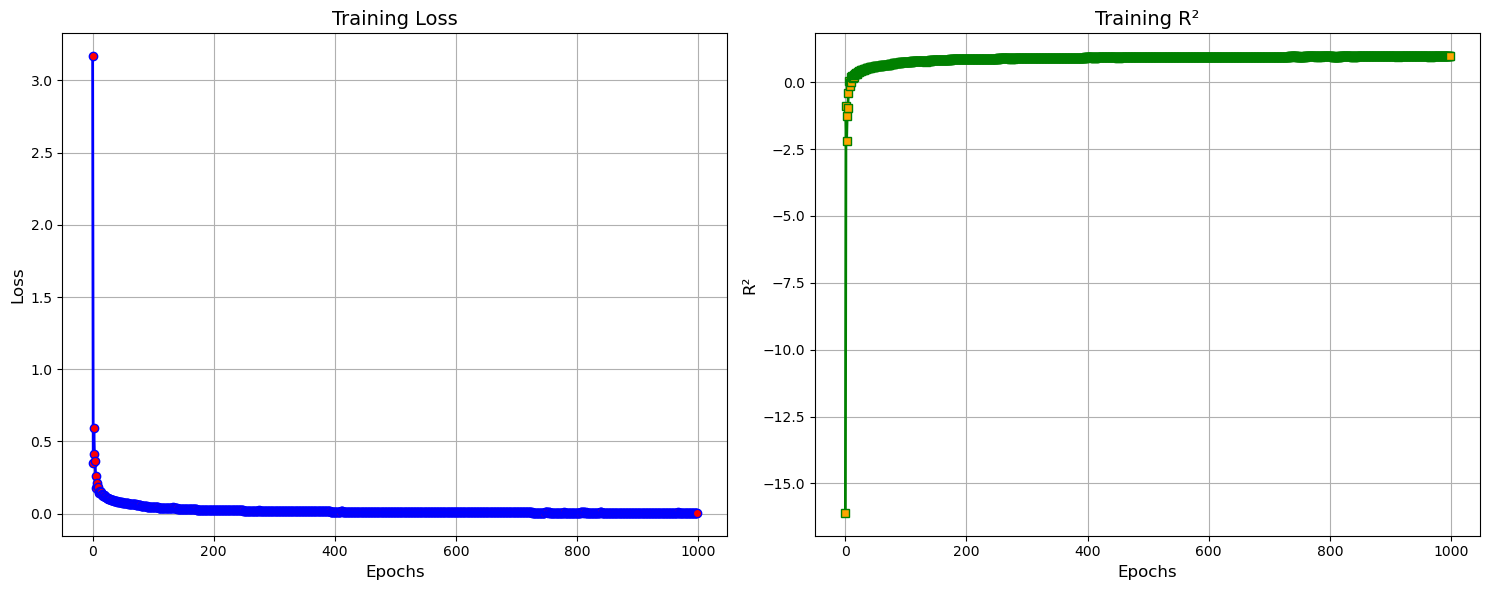

In [7]:
import matplotlib.pyplot as plt

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Plot training loss with markers
ax[0].plot(training_loss[1:], color='blue', linewidth=2, marker='o', markersize=6, markerfacecolor='red')
ax[0].set_title('Training Loss', fontsize=14)
ax[0].set_xlabel('Epochs', fontsize=12)
ax[0].set_ylabel('Loss', fontsize=12)
ax[0].grid(True)

# Plot training R^2 with markers
ax[1].plot(training_r2[1:], color='green', linewidth=2, marker='s', markersize=6, markerfacecolor='orange')
ax[1].set_title('Training R²', fontsize=14)
ax[1].set_xlabel('Epochs', fontsize=12)
ax[1].set_ylabel('R²', fontsize=12)
ax[1].grid(True)

# Add some space between subplots
plt.tight_layout()

# Show the plot
plt.show()


In [8]:
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# num_epochs = 10

# training_loss = []
# validation_loss = []
# training_r2 = []
# validation_r2 = []

# for i in trange(num_epochs):
#     model.train()
#     optimizer.zero_grad()
    
#     prediction = model(input_halo, input_params)
#     loss = criterion(prediction, output_xHI)
#     loss.backward()
#     optimizer.step()
    
#     training_loss.append(loss.item())
#     training_r2.append(r2_score(output_xHI.cpu().numpy().flatten(), prediction.cpu().detach().numpy().flatten()))
    
#     model.eval()
#     with torch.no_grad():
#         prediction = model(input_halo, val_params)
#         loss = criterion(prediction, val_xHI)
#         validation_loss.append(loss.item())
#         validation_r2.append(r2_score(val_xHI.cpu().numpy().flatten(), prediction.cpu().detach().numpy().flatten()))

In [9]:
# ModelSpecification = f"CosmoUiT{num_epochs}B11"
# #B11: Batche size 11 (fixed)
# #WR: With Rotation

# folder_path = f'/media/disk2/prasad/ModelOutputs/{ModelSpecification}/'
# if not os.path.exists(folder_path):
#     os.mkdir(folder_path)
    
# np.save(f'{folder_path}/TrainingLoss{ModelSpecification}.npy', arr=training_loss)
# np.save(f'{folder_path}/ValidationLoss{ModelSpecification}.npy', arr=validation_loss)
# np.save(f'{folder_path}/TrainingR2Score{ModelSpecification}.npy', arr=training_r2)
# np.save(f'{folder_path}/ValidationR2Score{ModelSpecification}.npy', arr=validation_r2)

In [10]:
# plt.figure(figsize=(10, 6))
# plt.plot(range(1, len(training_loss)), training_loss[1:], marker='o', label='Training Loss')
# plt.plot(range(1, len(validation_loss)), validation_loss[1:], marker='o', label='Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title(ModelSpecification)
# plt.grid(True)
# plt.legend()
# plt.savefig(f'{folder_path}/{ModelSpecification}Loss.png')
# plt.show()

In [11]:
# plt.figure(figsize=(10, 6))
# plt.plot(range(1, len(training_r2)), training_r2[1:], marker='o', label='Training R² Score')
# plt.plot(range(1, len(validation_r2)), validation_r2[1:], marker='o', label='Validation R² Score')
# plt.xlabel('Epochs')
# plt.ylabel('R² Score')
# plt.title(ModelSpecification)
# plt.grid(True)
# plt.legend()
# plt.savefig(f'{folder_path}/{ModelSpecification}R2Score.png')
# plt.show()

# Making Predicitons

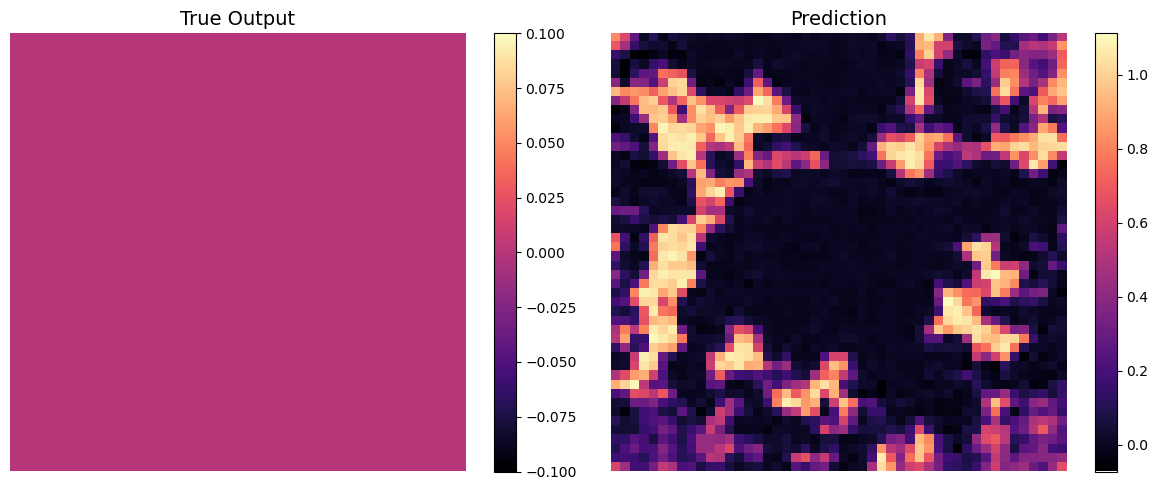

In [18]:
index=87
true_output = np.load(f'/media/disk2/prasad/ReducedData48/xHI{index}.npy')
input_params = torch.tensor(np.expand_dims(np.load('/media/disk2/prasad/Params.npy')[index], axis=0), dtype=torch.float32).to(device)
input_halo = input_halo[0].unsqueeze(0).to(device)
prediction = model(input_halo, input_params)
prediction = prediction.cpu().detach().numpy()
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot true output
im1 = ax[0].imshow(true_output[24], cmap='magma', aspect='auto')
ax[0].set_title('True Output', fontsize=14)
fig.colorbar(im1, ax=ax[0])
ax[0].axis('off')  # Optional: hide axes for a cleaner look

# Plot prediction
im2 = ax[1].imshow(prediction[0][0][24], cmap='magma', aspect='auto')
ax[1].set_title('Prediction', fontsize=14)
fig.colorbar(im2, ax=ax[1])
ax[1].axis('off')  # Optional: hide axes for a cleaner look

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


indices = [0, 76, 3500,  7203, 736, 5432, 5732, 587, 4101, 7018, 3]

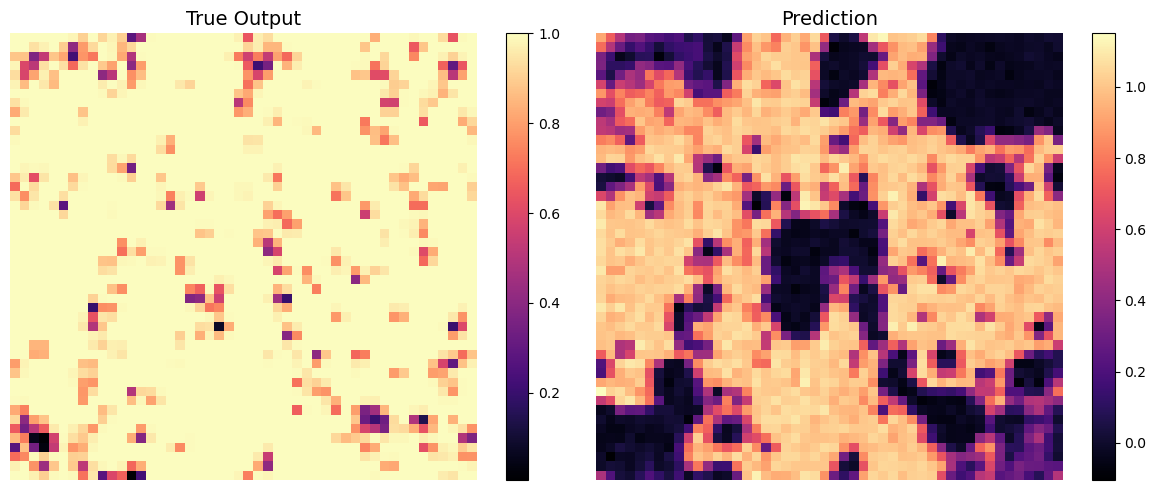

In [13]:
index=3456
true_output = np.load(f'/media/disk2/prasad/ReducedData48/xHI{index}.npy')
input_params = torch.tensor(np.expand_dims(np.load('/media/disk2/prasad/Params.npy')[index], axis=0), dtype=torch.float32).to(device)
input_halo = input_halo[0].unsqueeze(0).to(device)
prediction = model(input_halo, input_params)
prediction = prediction.cpu().detach().numpy()
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot true output
im1 = ax[0].imshow(true_output[24], cmap='magma', aspect='auto')
ax[0].set_title('True Output', fontsize=14)
fig.colorbar(im1, ax=ax[0])
ax[0].axis('off')  # Optional: hide axes for a cleaner look

# Plot prediction
im2 = ax[1].imshow(prediction[0][0][24], cmap='magma', aspect='auto')
ax[1].set_title('Prediction', fontsize=14)
fig.colorbar(im2, ax=ax[1])
ax[1].axis('off')  # Optional: hide axes for a cleaner look

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [19]:
torch.save(model.state_dict(), 'CosmoUiTE1000.pth')